# 2022-10-14 Preconditioning

## Last time

* Krylov methods (focus on GMRES)
* PETSc experiments
* Simple preconditioners

## Today
* Preconditioning building blocks
* Domain decomposition
* PETSc discussion
* Multigrid

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

# Simple preconditioners

## Jacobi `-pc_type jacobi`

$$ P_{\text{Jacobi}}^{-1} = D^{-1} $$
where $D$ is the diagonal of $A$.

## Gauss-Seidel `-pc_type sor`

$$ P_{GS}^{-1} = (L+D)^{-1} $$
where $L$ is the (strictly) lower triangular part of $A$.  The upper triangular part may be used instead, or a symmetric form
$$ P_{SGS}^{-1} = (L+U)^{-1} A \Big( I - (L+D)^{-1} \Big) . $$

### Over-relaxation

`-pc_sor_omega 1.` is default (Gauss-Seidel)

## Run p-Laplacian example
```console
$ cd src/snes/tutorials
$ make ex15
$ ./ex15 -da_refine 2 -dm_view
$ ./ex15 -ksp_monitor -pc_type jacobi
$ ./ex15 -snes_view
```

## Experiments

* How does iteration count vary under grid refinement?
* How sensitive is it to parameters
  * p-Laplacian `-p` $> 1$ and `-epsilon` $> 0$
  * Bratu `-lambda` $< 6.8$
* How sensitive to `-ksp_gmres_restart`?
* `-ksp_monitor_true_residual`
* `-ksp_view_eigenvalues`

# Incomplete factorization

* Start factoring like in a sparse direct solver
  * **ILU(0)** Discard fill outside the sparsity pattern of $A$
  * **ILU($k$)**: only allow $k$ levels of fill
  * **ILUT($\epsilon$)**: only keep fill values larger than $\epsilon$

## Experiments
* Try `-pc_factor_levels 2`
* Impact on cost (check `-log_view`)
* Impact on scalability (`-da_refine 6`)

## Kershaw (1978) matrix

Incomplete Cholesky can break down for SPD matrices.

```console
$ make $PETSC_ARCH/tests/ksp/pc/tutorials/ex1
```
and try running.

In [2]:
K = [3 -2 0 2; -2 3 -2 0; 0 -2 3 -2; 2 0 -2 3]
eigvals(K)

4-element Vector{Float64}:
 0.17157287525380904
 0.17157287525381085
 5.828427124746186
 5.82842712474619

# Domain decomposition

![](https://upload.wikimedia.org/wikipedia/commons/a/a9/Ddm_original_logo.png)

## Alternating Schwarz method
```python
bc_circ = guess()
while not converged:
    u_circ = solve(A_circ, bc_circ)
    bc_rect = eval(u_circ, rect)
    u_rect = solve(A_rect, bc_rect)
    bc_circ = eval(u_rect, circ)
```

This method was proposed in 1870 by [Hermann Schwarz](https://en.wikipedia.org/wiki/Hermann_Schwarz) as a theoretical tool, and is now called a **multiplicative** Schwarz method because the solves depend on each other.  We can see it as a generalization of Gauss-Seidel in which we solve on subdomains instead of at individual grid points.  As with Gauss-Seidel, it is difficult to expose parallelism.

# Additive Schwarz

The additive Schwarz method is more comparable to Jacobi, with each domain solved in parallel.  Our fundamental operation will be an embedding of each subdomain $V_i$ into the global domain $V$, which we call the **prolongation**

$$ P_i : V_i \to V $$

The transpose of prolongation, $P_i^T$, will sometimes be called **restriction**.
Let's work an example.

In [3]:
n = 21
x = LinRange(-1, 1, n)
overlap = 0
domains = [(1, n÷3), (n÷3+1, 2*n÷3), (2*n÷3+1, n)]
Id = diagm(ones(n))
P = []
for (i, (left, right)) in enumerate(domains)
    push!(P, Id[:, left:right])
end

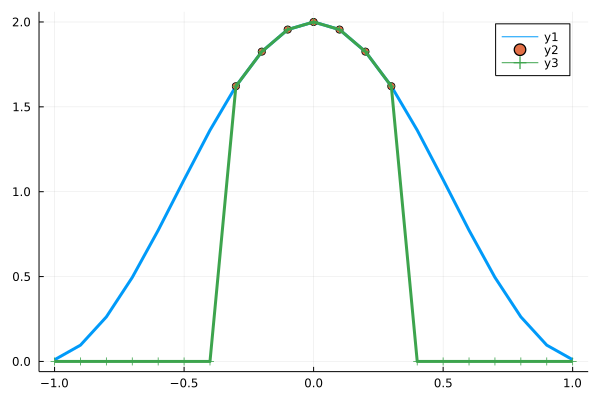

In [4]:
u = 1 .+ cos.(3*x)
plot(x, u)
u_2 = P[2]' * u
scatter!(P[2]' * x, u_2)
plot!(x, P[2] * u_2, marker=:auto)

# The algorithm

Define the subdomain operator $$A_i = P_i^T A P_i$$
The additive Schwarz preconditioner is
$$ M^{-1} = \sum_i P_i A_i^{-1} P_i^T $$
and it has error iteration matrix
$$ I - \sum_i  P_i A_i^{-1} P_i^T A $$

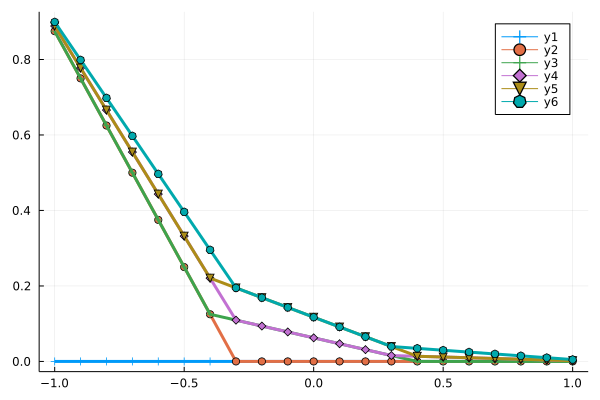

In [5]:
A = diagm(0 => 2*ones(n), -1 => -ones(n-1), 1 => -ones(n-1))
b = zeros(n); b[1] = 1
u = zero(b) # initial guess
us = [u]
for _ in 1:5
    r = b - A * u # residual
    u_next = copy(u);
    for Pi in P
        Ai = Pi' * A * Pi
        ui = Ai \ (Pi' * r)
        u_next += Pi * ui
    end
    u = u_next; push!(us, u)
end
plot(x, us, marker=:auto)

# Theory
Given a linear operator $A : V \to V$, suppose we have a collection of prolongation operators $P_i : V_i \to V$.  The columns of $P_i$ are "basis functions" for the subspace $V_i$.  The Galerkin operator $A_i = P_i^T A P_i$ is the action of the original operator $A$ in the subspace.

Define the subspace projection

$$ S_i = P_i A_i^{-1} P_i^T A . $$

* $S_i$ is a projector: $S_i^2 = S_i$
* If $A$ is SPD, $S_i$ is SPD with respect to the $A$ inner product $x^T A y$
* $I - S_i$ is $A$-orthogonal to the range of $P_i$

In [6]:
A2 = P[2]' * A * P[2]
S2 = P[2] * inv(A2) * P[2]' * A
norm(S2^2 - S2)

1.2036131040197588e-15

In [7]:
norm(P[2]' * A * (I - S2))

1.1831170202396054e-15

**Note:** The concept of $A$-orthogonality is meaningful only when $A$ is SPD.
Does the mathematical expression $ P_i^T A (I - S_i) = 0 $ hold even when $A$ is nonsymmetric?

# Convergence theory

The formal convergence is beyond the scope of this course, but the following estimates are useful.  We let $h$ be the element diameter, $H$ be the subdomain diameter, and $\delta$ be the overlap, each normalized such that the global domain diameter is 1.  We express the convergence in terms of the condition number $\kappa$ for the preconditioned operator.

* (Block) Jacobi: $\delta=0$, $\kappa \sim H^{-2} H/h = (Hh)^{-1}$
* Overlapping Schwarz: $\kappa \sim H^{-2} H/\delta = (H \delta)^{-1}$
* 2-level overlapping Schwarz: $\kappa \sim H/\delta$

* Additive $ I - \sum_{i=0}^n S_i, $

* Multiplicative $ \prod_{i=0}^n (I - S_i), $
* Hybrid $ (I - S_0) (I - \sum_{i=1}^n S_i) . $

In each case above, the action is expressed in terms of the error iteration operator.

# PETSc experiments

* Compare domain decomposition and multigrid preconditioning
 * `-pc_type asm` (Additive Schwarz)
  * `-pc_asm_type basic` (symmetric, versus `restrict`)
  * `-pc_asm_overlap 2` (increase overlap)
  * Effect of direct subdomain solver: `-sub_pc_type lu`

* Symmetric example: `src/snes/examples/tutorials/ex5.c`
* Nonsymmetric example: `src/snes/examples/tutorials/ex19.c`
* Compare preconditioned versus unpreconditioned norms.
* Compare BiCG versus GMRES
 * `-pc_type mg` (Geometric Multigrid)
* Use monitors:
 * `-ksp_monitor_true_residual`
 * `-ksp_monitor_singular_value`
 * `-ksp_converged_reason`
* Explain methods: `-snes_view`
* Performance info: `-log_view`

# Geometric multigrid and the spectrum

Multigrid uses a hierarchy of scales to produce an operation "$M^{-1}$" that can be applied in $O(n)$ ("linear") time and such that $\lVert I - M^{-1} A \rVert \le \rho < 1$ independent of the problem size.
We'll consider the one dimensional Laplacian using the stencil
$$ \Big(\frac{h^2}{2}\Big) \frac{1}{h^2} \begin{bmatrix} -1 & 2 & -1 \end{bmatrix} $$

In [32]:
function laplace1d(n)
    "1D Laplacion with Dirichlet boundary conditions eliminated"
    h = 2 / (n + 1)
    x = LinRange(-1, 1, n+2)[2:end-1]
    A = diagm(0 => ones(n),
        -1 => -.5*ones(n-1),
        +1 => -.5*ones(n-1))
    x, A # Hermitian(A)
end

laplace1d (generic function with 1 method)

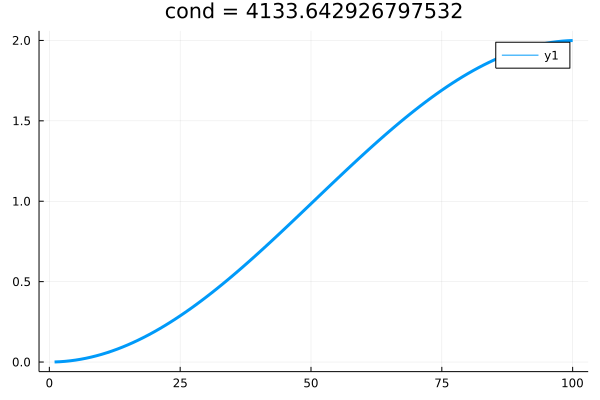

In [33]:
x, A = laplace1d(100)
L, X = eigen(A)
#@show L[1:2]
#@show L[end-2:end]
plot(L, title="cond = $(L[end]/L[1])")

# What do the eigenvectors look like?

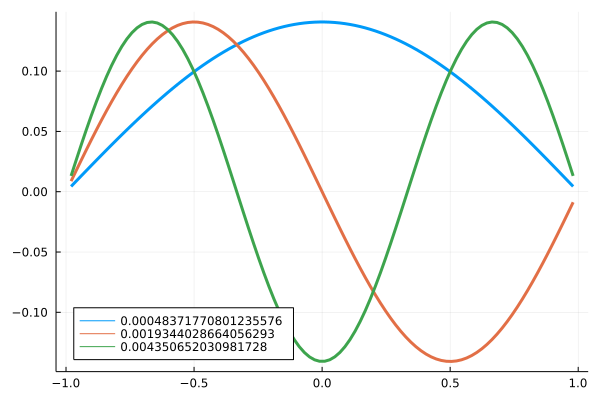

In [34]:
x, A = laplace1d(100)
L, X = eigen(A)
plot(x, X[:,1:3], label=L[1:3]', legend=:bottomleft)

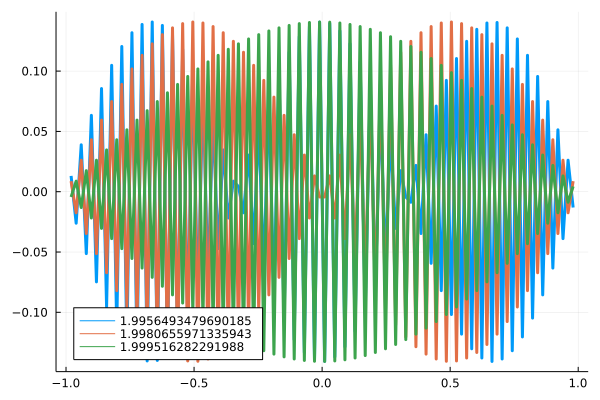

In [35]:
plot(x, X[:, end-2:end], label=L[end-2:end]', legend=:bottomleft)

# Condition number grows with grid refinement

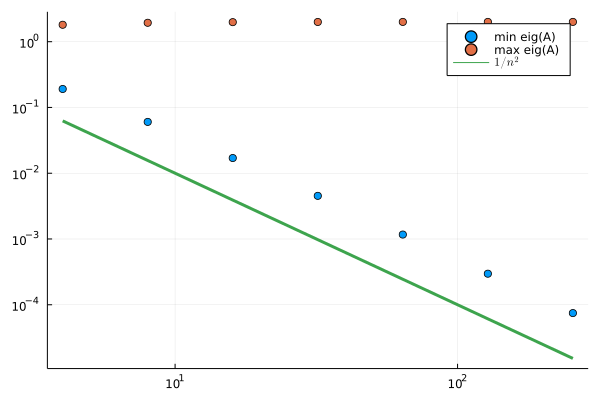

In [36]:
ns = 2 .^ (2:8)
eigs = vcat([eigvals(laplace1d(n)[2])[[1, end]] for n in ns]'...)

scatter(ns, eigs, label=["min eig(A)" "max eig(A)"])
plot!(n -> 1/n^2, label="\$1/n^2\$", xscale=:log10, yscale=:log10)

# Fourier analysis perspective

Consider the basis $\phi(x, \theta) = e^{i \theta x}$.  If we choose the grid $x \in h \mathbb Z$ with grid size $h$ then we can resolve frequencies $\lvert \theta \rvert \le \pi/h$.

In [37]:
function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

function plot_symbol(S, deriv=2; plot_ref=true, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    if plot_ref
        plot!(fig, th -> th^deriv, label="exact")
    end
    fig
end

plot_symbol (generic function with 2 methods)

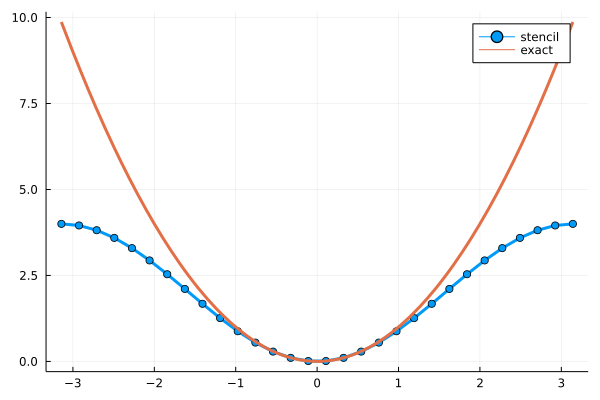

In [38]:
plot_symbol([1 -2 1])
#plot!(xlims=(-1, 1))

# Analytically computing smallest eigenvalue

The longest wavelength for a domain size of 2 with Dirichlet boundary conditions is 4. The frequency is $\theta = 2\pi/\lambda = \pi/2$. The `symbol` function works on an integer grid. We can transform via $\theta \mapsto \theta h$.

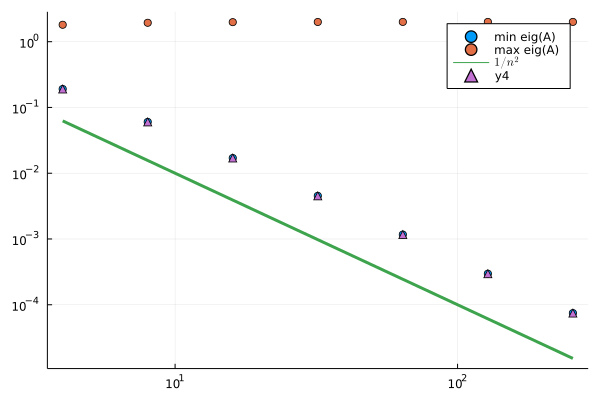

In [39]:
scatter(ns, eigs, label=["min eig(A)" "max eig(A)"])
plot!(n -> 1/n^2, label="\$1/n^2\$", xscale=:log10, yscale=:log10)
theta_min = pi ./ (ns .+ 1)
symbol_min = -real(symbol([1 -2 1], theta_min))
scatter!(ns, symbol_min / 2, shape=:utriangle)

# Damping properties of Richardson/Jacobi relaxation

Recall that we would like for $I - w A$ to have a small norm, such that powers (repeat iterations) will cause the error to decay rapidly.

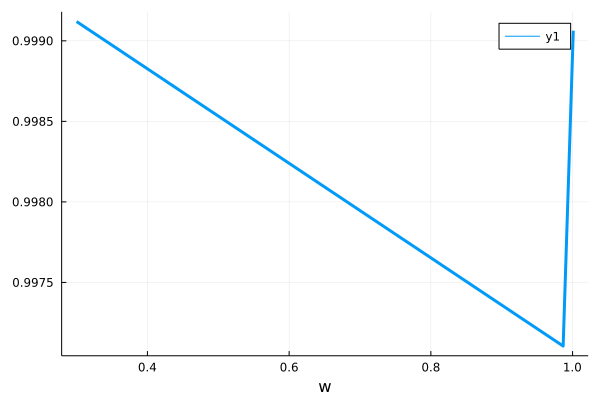

In [40]:
x, A = laplace1d(40)
ws = LinRange(.3, 1.001, 50)
radius = [opnorm(I - w*A) for w in ws]
plot(ws, radius, xlabel="w")

* The spectrum of $A$ runs from $\theta_{\min}^2$ up to 2.  If $w > 1$, then $\lVert I - w A \rVert > 1$ because the operation amplifies the high frequencies (associated with the eigenvalue of 2).
* The value of $w$ that minimizes the norm is slightly less than 1, but the convergence rate is very slow (only barely less than 1).

# Symbol of damping

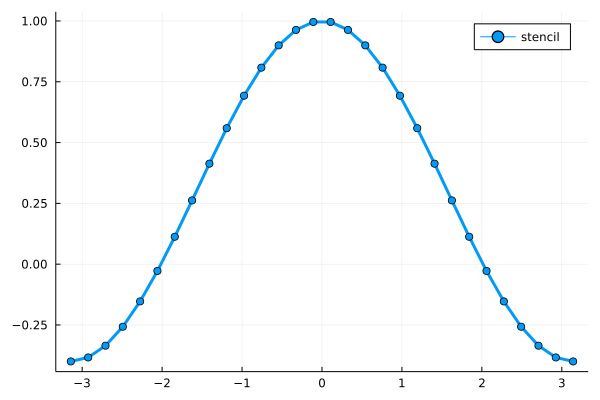

In [41]:
w = .7
plot_symbol([0 1 0] - w * [-.5 1 -.5], 0; plot_ref=false)

* Evidently it is very difficult to damp low frequencies.
* This makes sense because $A$ and $I - wA$ move information only one grid point per iteration.
* It also makes sense because the polynomial needs to be 1 at the origin, and the low frequencies have eigenvalues very close to zero.

# Coarse grids: Make low frequencies high (again)

As in domain decomposition, we will express our "coarse" subspace, consisting of a grid $x \in 2h\mathbb Z$, in terms of its interpolation to the fine space.  Here, we'll use linear interpolation.

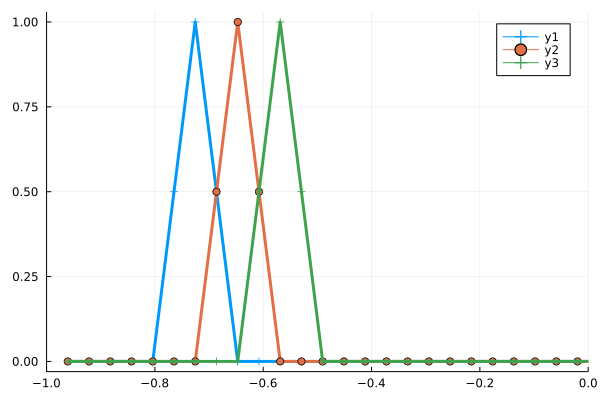

In [42]:
function interpolate(m, stride=2)
    s1 = (stride - 1) / stride
    s2 = (stride - 2) / stride
    P = diagm(0 => ones(m),
        -1 => s1*ones(m-1), +1 => s1*ones(m-1),
        -2 => s2*ones(m-2), +2 => s2*ones(m-2))
    P[:, 1:stride:end]
end
n = 50; x, A = laplace1d(n)
P = interpolate(n, 2)
plot(x, P[:, 4:6], marker=:auto, xlims=(-1, 0))

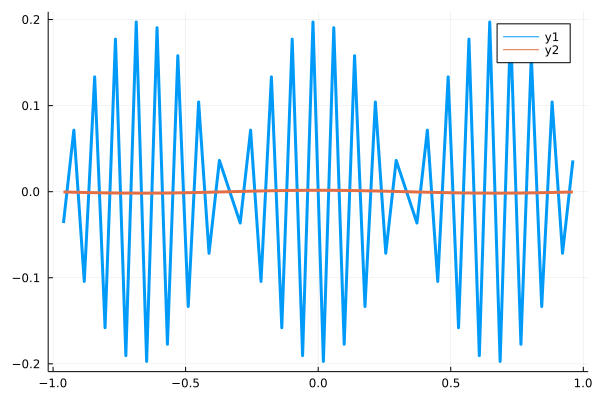

In [43]:
L, X = eigen(A)
u_h = X[:, 48]
u_2h = .5 * P' * u_h
plot(x, [u_h, P * u_2h])

# Galerkin approximation of $A$ in coarse space

$$ A_{2h} u_{2h} = P^T A_h P u_{2h} $$

size(A) = (50, 50)
size(A_2h) = (25, 25)


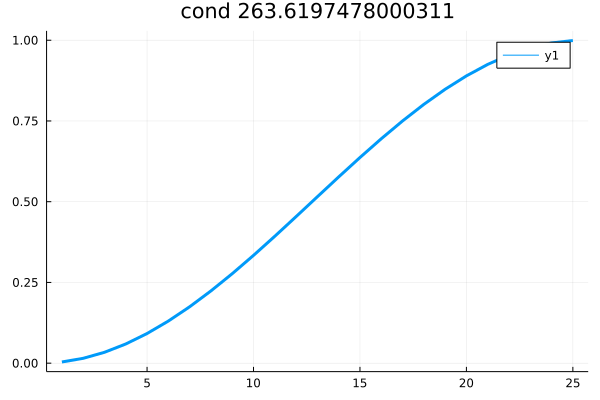

In [44]:
x, A = laplace1d(n)
P = interpolate(n)
@show size(A)
A_2h = P' * A * P
@show size(A_2h)
L_2h = eigvals(A_2h)
plot(L_2h, title="cond $(L_2h[end]/L_2h[1])")

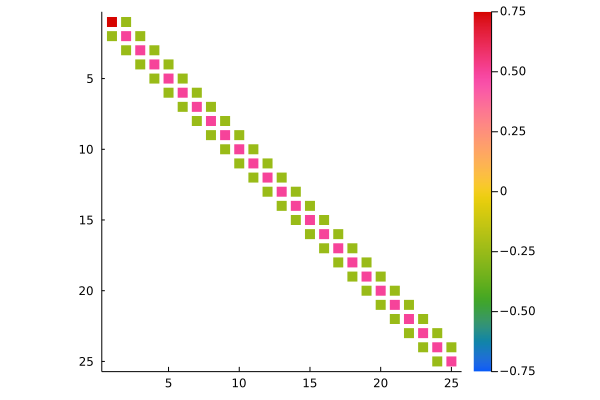

In [45]:
my_spy(A_2h)

# Coarse grid correction

Consider the $A$-orthogonal projection onto the range of $P$,
$$ S_c = P A_{2h}^{-1} P^T A $$

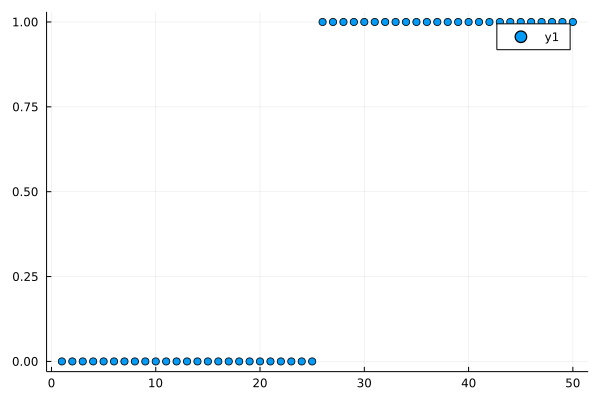

In [46]:
Sc = P * (A_2h \ P' * A)
Ls, Xs = eigen(I - Sc)
scatter(real.(Ls))

* This spectrum is typical for a projector. If $u$ is in the range of $P$, then $S_c u = u$. Why?
* For all vectors $v$ that are $A$-orthogonal to the range of $P$, we know that $S_c v = 0$. Why?

# A two-grid method

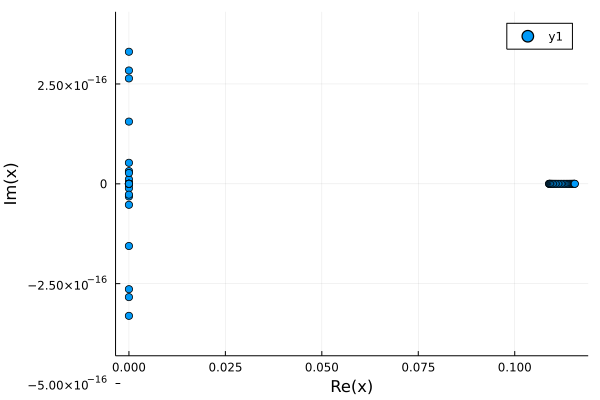

┌ Warning: No strict ticks found
└ @ PlotUtils /home/jed/.julia/packages/PlotUtils/NE7U1/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/jed/.julia/packages/PlotUtils/NE7U1/src/ticks.jl:191


In [47]:
w = .67
T = (I - w*A) * (I - Sc) * (I - w*A)
Lt = eigvals(T)
scatter(Lt)

* Can analyze these methods in terms of frequency.
* [LFAToolkit](https://jeremylt.github.io/LFAToolkit.jl/stable/examples/diffusion/#Diffusion-operator)

# Multigrid as factorization

We can interpret factorization as a particular multigrid or domain decomposition method.

We can partition an SPD matrix as
$$A = \begin{bmatrix} F & B^T \\ B & D \end{bmatrix}$$
and define the preconditioner by the factorization
$$      M = \begin{bmatrix} I & \\ B F^{-1} & I \end{bmatrix}
      \begin{bmatrix} F &  \\ & S \end{bmatrix}
      \begin{bmatrix} I & F^{-1}B^T \\  & I \end{bmatrix}
$$
where $S = D - B F^{-1} B^T$.  $M$ has an inverse
$$
      \begin{bmatrix} I & -F^{-1}B^T \\  & I \end{bmatrix}
      \begin{bmatrix} F^{-1} &  \\ & S^{-1} \end{bmatrix}
      \begin{bmatrix} I & \\ -B F^{-1} & I \end{bmatrix} .
$$

Define the interpolation
$$ P_f = \begin{bmatrix} I \\ 0 \end{bmatrix}, \quad P_c = \begin{bmatrix} -F^{-1} B^T \\ I \end{bmatrix} $$ and rewrite as
$$ M^{-1} = [P_f\  P_c] \begin{bmatrix} F^{-1} P_f^T \\ S^{-1} P_c^T \end{bmatrix} = P_f F^{-1} P_f^T + P_c S^{-1} P_c^T.$$
The iteration matrix is thus
$$ I - M^{-1} A = I - P_f F^{-1} P_f^T J - P_c S^{-1} P_c^T A .$$

# Permute into C-F split

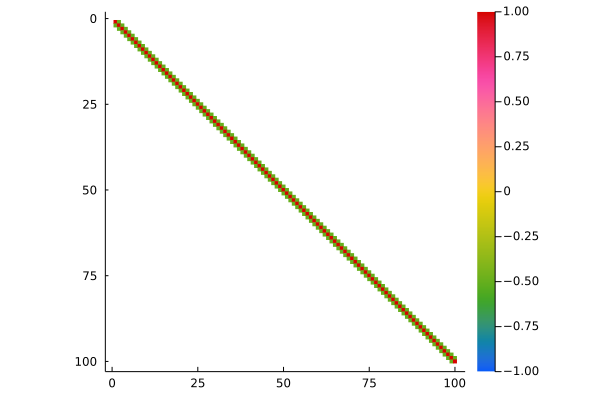

In [48]:
m = 100
x, A = laplace1d(m)
my_spy(A)

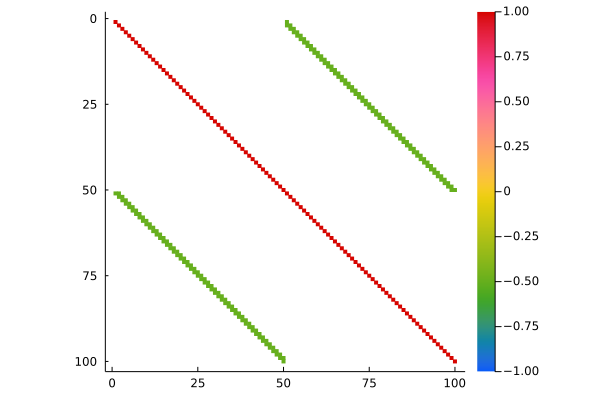

In [49]:
idx = vcat(1:2:m, 2:2:m)
J = A[idx, idx]
my_spy(J)

# Coarse basis functions

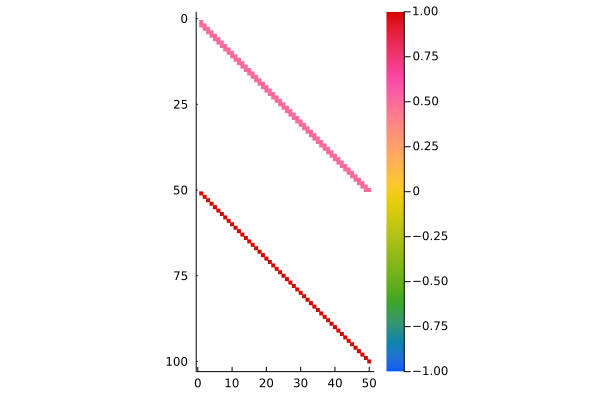

In [50]:
F = J[1:end÷2, 1:end÷2]
B = J[end÷2+1:end,1:end÷2]
P = [-F\B'; I]
my_spy(P)

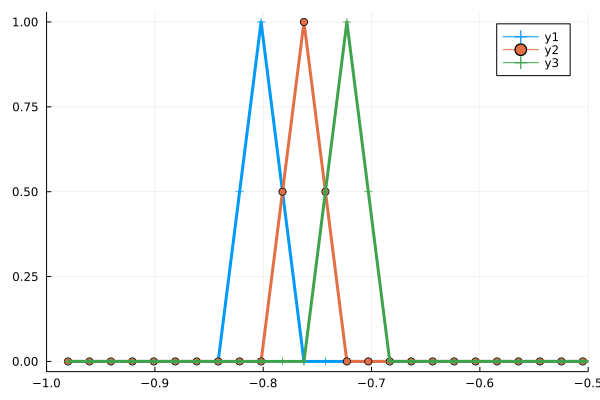

In [51]:
idxinv = zeros(Int64, m)
idxinv[idx] = 1:m
Pp = P[idxinv, :]
plot(x, Pp[:, 5:7], marker=:auto, xlims=(-1, -.5))

# From factorization to algebraic multigrid

* Factorization as a multigrid (or domain decomposition) method incurs significant cost in multiple dimensions due to lack of sparsity.
  * We can't choose enough coarse basis functions so that $F$ is diagonal, thereby making the minimal energy extension $-F^{-1} B^T$ sparse.

* Algebraic multigrid
  * Use matrix structure to aggregate or define C-points
  * Create an interpolation rule that balances sparsity with minimal energy

# Aggregation

Form aggregates from "strongly connected" dofs.

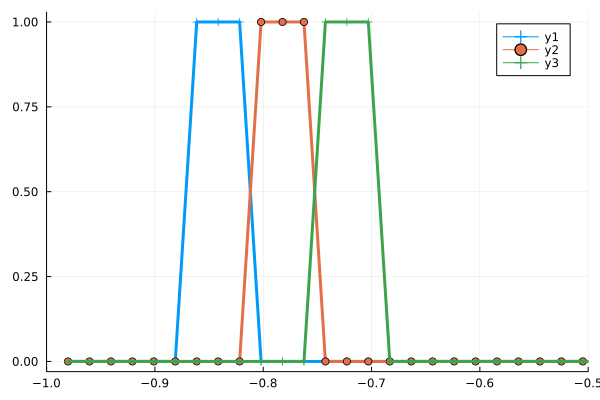

In [52]:
agg = 1 .+ (0:m-1) .÷ 3
mc = maximum(agg)
T = zeros(m, mc)
for (i, j) in enumerate(agg)
    T[i,j] = 1
end
plot(x, T[:, 3:5], marker=:auto, xlims=(-1, -.5))

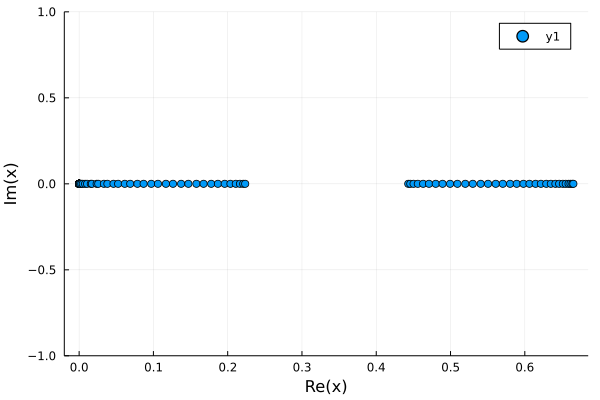

In [53]:
Sc = T * ((T' * A * T) \ T') * A
w = .67; k = 1
E = (I - w*A)^k * (I - Sc) * (I - w*A)^k
scatter(eigvals(E), ylims=(-1, 1))

* simple and cheap method
* stronger smoothing (bigger `k`) doesn't help much; need more accurate coarse grid

# Smoothed aggregation

$$ P = (I - w A) T $$

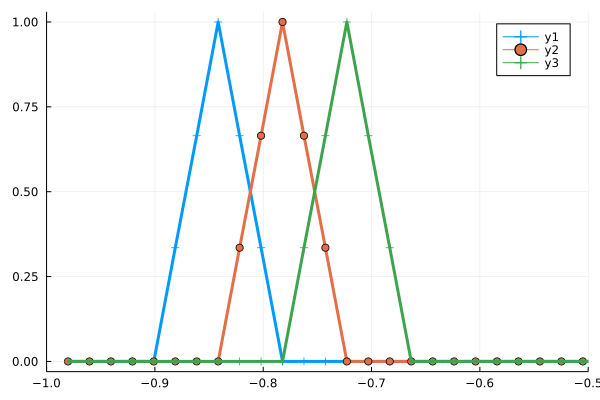

In [54]:
P = (I - w * A) * T
plot(x, P[:, 3:5], marker=:auto, xlims=(-1,-.5))

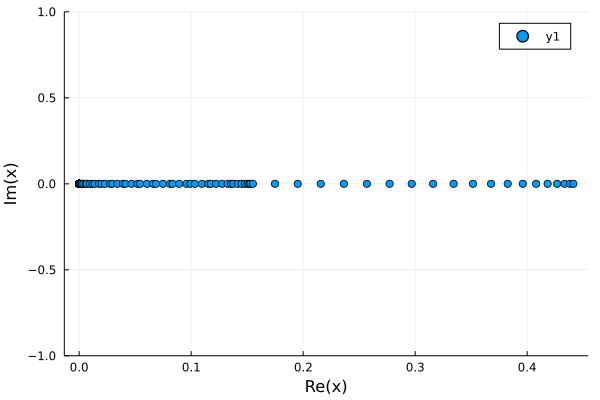

In [55]:
Sc = P * ((P' * A * P) \ P') * A
w = .67; k = 1
E = (I - w*A)^k * (I - Sc) * (I - w*A)^k
scatter(eigvals(E), ylims=(-1, 1))

* Eigenvalues are closer to zero; stronger smoothing (larger `k`) helps.
* Smoother can be made stronger using Chebyshev (like varying the damping between iterations in Jacobi)

# Multigrid in PETSc

## Geometric multigrid

* `-pc_type mg`
  * needs a grid hierarchy (automatic with `DM`)
  * `PCMGSetLevels()`
  * `PCMGSetInterpolation()`
  * `PCMGSetRestriction()`
* `-pc_mg_cycle_type [v,w]`
* `-mg_levels_ksp_type chebyshev`
* `-mg_levels_pc_type jacobi`
* `-mg_coarse_pc_type svd`
  * `-mg_coarse_pc_svd_monitor` (report singular values/diagnose singular coarse grids)

## Algebraic multigrid

* `-pc_type gamg`
  * native PETSc implementation of smoothed aggregation (and experimental stuff), all `-pc_type mg` options apply.
  * [`MatSetNearNullSpace()`](https://petsc.org/release/docs/manualpages/Mat/MatSetNearNullSpace/)
  * [`MatNullSpaceCreateRigidBody()`](https://petsc.org/release/docs/manualpages/Mat/MatNullSpaceCreateRigidBody/)
  * [`DMPlexCreateRigidBody()`](https://petsc.org/release/docs/manualpages/DMPlex/DMPlexCreateRigidBody/)
  * `-pc_gamg_threshold .01` drops weak edges in strength graph
* `-pc_type ml`
  * similar to `gamg` with different defaults
* `-pc_type hypre`
  * Classical AMG (based on C-F splitting)
  * Manages its own grid hierarchy